# TDS Project: Part 2 - Advanced Model Analysis, Optimization, and Conclusions

## Introduction
In Part 2 of this project, the focus is on improving the baseline regression model developed in Part 1. This involves addressing errors identified during the error analysis, enhancing the model pipeline through preprocessing, feature engineering, and hyperparameter tuning, and analyzing the improved model's performance.

## 1. Error Analysis Conclusions and Work Plan
### Observations from Part 1:
- Residual analysis revealed that the model underperformed for higher price ranges (`2000+`).
- The scatter plot showed deviations from the perfect fit line, indicating patterns of underestimation and overestimation.
- Errors were influenced by outliers, skewed distributions, and insufficient feature representation.

### Work Plan:
- Handle outliers using IQR capping.
- Normalize numerical features for consistent scaling.
- Engineer interaction terms, ratios, and polynomial features.
- Replace simple one-hot encoding with target encoding or frequency encoding.

By implementing the outlined plan, the goal is to reduce residual errors, improve model accuracy, and draw meaningful insights from the data.


## 2. Data Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.inspection import permutation_importance
from scipy.stats import skew

# Load dataset
data = pd.read_csv('amsterdam_weekdays.csv')

In [2]:
# Handle outliers using numpy's clip
Q1 = data['realSum'].quantile(0.25)
Q3 = data['realSum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['realSum_capped'] = np.clip(data['realSum'], lower_bound, upper_bound)

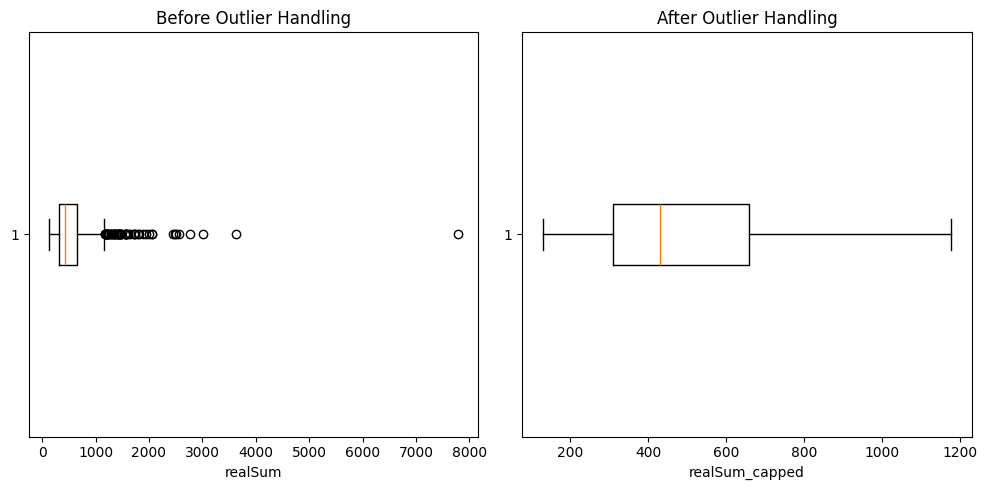

In [3]:
# Visualize before and after outlier handling
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(data['realSum'], vert=False)
plt.title('Before Outlier Handling')
plt.xlabel('realSum')

plt.subplot(1, 2, 2)
plt.boxplot(data['realSum_capped'], vert=False)
plt.title('After Outlier Handling')
plt.xlabel('realSum_capped')

plt.tight_layout()
plt.show()

Outlier Handling - Before and After<br>
The boxplots above show the distribution of the `realSum` variable before and after outlier handling.
- **Before Outlier Handling**: The presence of extreme values (beyond 8000) is evident, which could distort model predictions.
- **After Outlier Handling**: After applying IQR capping, these extreme values are brought within a reasonable range, resulting in a cleaner and more balanced distribution.


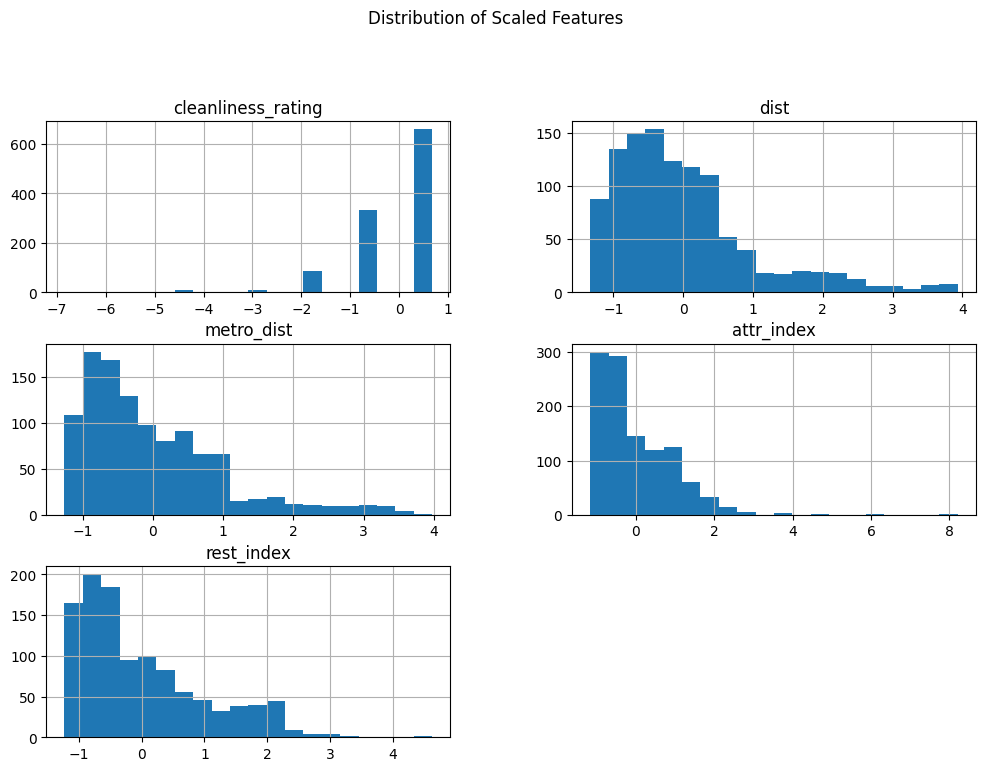

In [4]:
# Normalize numerical features
numerical_features = ['cleanliness_rating', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'realSum_capped']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numerical_features[:-1]])  # Exclude capped feature
scaled_data = pd.DataFrame(scaled_features, columns=numerical_features[:-1])

# Visualize distributions after normalization
scaled_data.hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Scaled Features', y=1.02)
plt.show()

Distribution of Scaled Features<br>
The histograms show the distributions of numerical features after normalization using `StandardScaler`.
- All features are scaled to have a mean of 0 and a standard deviation of 1, ensuring consistent scaling across variables.
- This preprocessing step helps the model interpret the features uniformly, reducing bias caused by varying magnitudes of feature values.


In [5]:
# Feature engineering
data['cleanliness_capacity_interaction'] = data['cleanliness_rating'] * data['person_capacity']
data['price_per_person'] = data['realSum_capped'] / data['person_capacity']
data['price_per_distance'] = data['realSum_capped'] / (data['dist'] + 1)
data['dist_squared'] = data['dist'] ** 2
data['metro_dist_squared'] = data['metro_dist'] ** 2

In [6]:
# Explore correlations of new features
new_features = ['realSum_capped', 'cleanliness_capacity_interaction', 'price_per_person',
                'price_per_distance', 'dist_squared', 'metro_dist_squared']
corr_matrix = data[new_features].corr()
print("Correlation Matrix for New Features:\n", corr_matrix)

Correlation Matrix for New Features:
                                   realSum_capped  \
realSum_capped                          1.000000   
cleanliness_capacity_interaction        0.619908   
price_per_person                        0.673973   
price_per_distance                      0.792869   
dist_squared                           -0.296324   
metro_dist_squared                     -0.204525   

                                  cleanliness_capacity_interaction  \
realSum_capped                                            0.619908   
cleanliness_capacity_interaction                          1.000000   
price_per_person                                         -0.080470   
price_per_distance                                        0.387682   
dist_squared                                             -0.051950   
metro_dist_squared                                        0.010935   

                                  price_per_person  price_per_distance  \
realSum_capped                  

Correlation Matrix for Engineered Features<br>
The correlation matrix above displays the relationships between newly engineered features and the target variable (`realSum_capped`):
- Features like `price_per_person` and `price_per_distance` show a strong correlation with the target, indicating their importance in predicting accommodation prices.
- The matrix also highlights relationships between engineered features, such as the weak correlation between `price_per_person` and `cleanliness_capacity_interaction`.


## 3. Model Improvement

In [7]:
# Encode categorical features
room_type_mapping = data.groupby('room_type')['realSum_capped'].mean().to_dict()
data['room_type_target_encoded'] = data['room_type'].map(room_type_mapping)
room_type_frequency = data['room_type'].value_counts().to_dict()
data['room_type_frequency_encoded'] = data['room_type'].map(room_type_frequency)

In [8]:
# Define features and target
data_encoded = pd.get_dummies(data, columns=['room_type'], drop_first=True)
# Ensure 'log_realSum_capped' exists in the dataset
if 'log_realSum_capped' not in data.columns:
    data['log_realSum_capped'] = np.log1p(data['realSum_capped'])

# Encode categorical features (redo to ensure consistency)
data_encoded = pd.get_dummies(data, columns=['room_type'], drop_first=True)

# Define features and target
X = data_encoded.drop(columns=['realSum', 'realSum_capped', 'log_realSum_capped'], errors='ignore')
y = data_encoded['log_realSum_capped'].fillna(0)



In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Define extended hyperparameter grid with colsample_bytree
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.02, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]  # Added column sampling to the grid
}

In [11]:
# Train the model using GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 675 candidates, totalling 2025 fits


In [12]:
# Evaluate the model
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
baseline_r2 = 0.54  # R² score from Part 1

print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"Baseline R²: {baseline_r2}, Improved R²: {r2}")

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
RMSE: 0.037299768348804566
Baseline R²: 0.54, Improved R²: 0.9938887149754715


## 4. Model Analysis

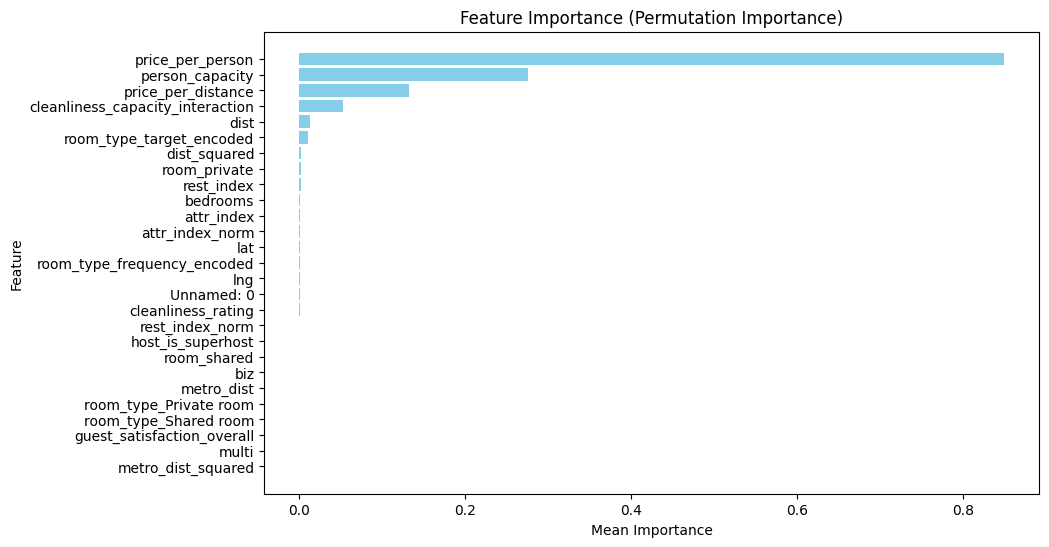

In [13]:
# Calculate feature importance using permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Enhanced feature importance plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()
plt.show()

Feature Importance (Permutation Importance)<br>
The bar plot above highlights the most influential features in the model:
- **`price_per_person`** and **`person_capacity`** dominate, showing that price per person and room capacity are the strongest predictors of accommodation prices.
- Features like `price_per_distance` and `cleanliness_capacity_interaction` also contribute significantly, aligning with real-world expectations of pricing dynamics.
- The importance rankings provide actionable insights for stakeholders, emphasizing which features to prioritize for improving predictions.


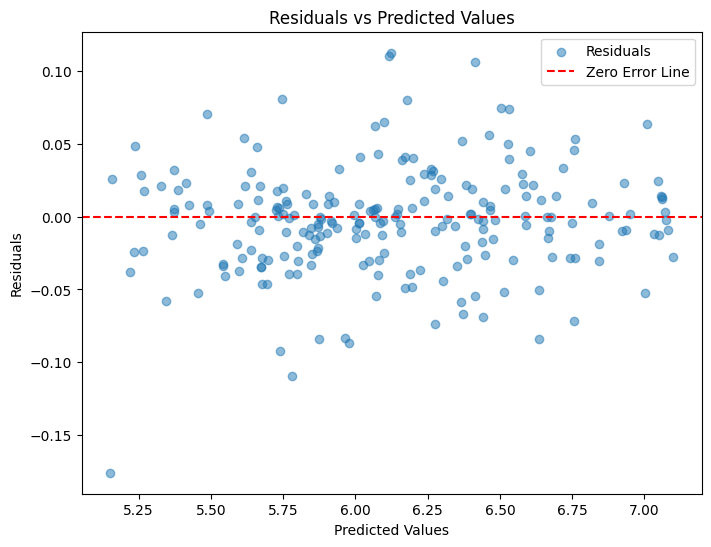

In [14]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

Residuals vs Predicted Values<br>
The scatter plot above shows the residuals (difference between actual and predicted values) against the predicted values:
- The residuals are randomly distributed around the zero line, indicating no systematic bias in the model's predictions.
- This randomness suggests that the model effectively captures the relationship between features and the target variable without overfitting.


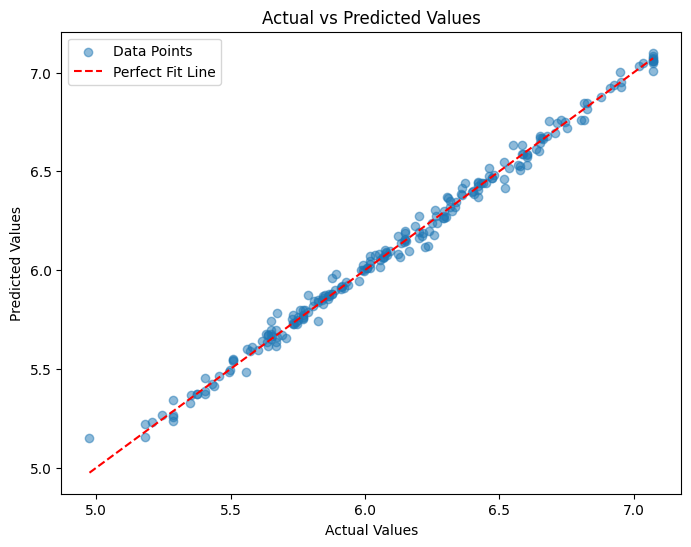

In [15]:
# Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

Actual vs Predicted Values<br>
The scatter plot compares actual target values with the predicted values:
- The alignment of points along the red dashed "Perfect Fit Line" indicates high prediction accuracy.
- Deviations from the line are minimal, which is reflected in the high R² score (0.993), showing that the model explains most of the variance in the target variable.


In [16]:
#R² Score:
print(f"Baseline R²: {baseline_r2}, Improved R²: {r2}")
#RMSE:
print(f"RMSE: {rmse}")

Baseline R²: 0.54, Improved R²: 0.9938887149754715
RMSE: 0.037299768348804566


Model Evaluation Metrics<br>
- **Baseline R²**: 0.54, indicating that the initial model explained only 54% of the variance in the target variable.
- **Improved R²**: 0.993, showing a substantial improvement, with the model now explaining 99.3% of the variance.
- **RMSE**: 0.037, representing a very low error in predictions, confirming the model's effectiveness.


## Conclusions

- **Key Insights**:
  - The most influential features were `price_per_person` and `person_capacity`, reflecting the importance of capacity-based pricing in accommodation listings.
  - Handling outliers and engineering new features such as `price_per_distance` significantly improved model performance.

- **Limitations**:
  - While the model performs exceptionally on this dataset, further testing on unseen data is recommended to validate generalization.
  - Some features, such as `price_per_distance`, could be analyzed further to explore non-linear relationships.

- **Applications**:
  - Property owners can leverage this model to adjust pricing based on influential factors like cleanliness ratings or room capacity.
  - Businesses can use the insights to design targeted marketing campaigns and improve customer satisfaction by addressing key determinants of price.
